# Load Data

In [3]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import database as db
import pandas_ta as ta
import helpers
import os

pd.set_option('display.max_rows', 100)


# Data Parameters
data_path  = './data'
feature_path = './feature'
instrument = 'EG'
freq = '15min'
dates = db.GetTradeDates(instrument)[:]

# Read CSV Data
big = []
for date in dates:
    df = pd.read_csv(data_path + os.sep + instrument + os.sep + date + '.csv', index_col=0)
    df.index = pd.to_datetime(df.index)
    df['MidPrice'] = 0.5* (df['BidPrice1'] + df['AskPrice1'])
    ohlc = helpers.GetOHLC(df, freq)
    ohlc[['Contract', 'TradeDate', 'PreClose']] = df['InstrumentID'].iloc[0], df['TradingDay'].iloc[0], df['PreClosePrice'].iloc[0]
    
    big.append(ohlc)

big = pd.concat(big, axis=0)
#macd = big.ta.macd(fast=12, slow=26, signal=9, offset=0)
#big = pd.concat([big, macd], axis=1)
#big.to_csv(feature_path + os.sep + '{}_feature_{}.csv'.format(instrument, freq))

# Simple MACD Plot

In [4]:
import utils
from plotly.subplots import make_subplots
import plotly.graph_objects as go
N=6
df = big.ta.macd(fast=12, slow=26, signal=9, offset=0)
df['close'] = big.close.values
df['TradeDate'] = big['TradeDate'].values
# df['f__RSI_LSDeviate'] = df.eval(f'rsi_{N} - rsi_4{N}')
df['f__MACD_GCross'] = np.where((df['MACDh_12_26_9'] > 0) & (df['MACDh_12_26_9'].shift(1) < 0) , df['close'], np.nan)
df['f__MACD_DCross'] = np.where((df['MACDh_12_26_9'] < 0) & (df['MACDh_12_26_9'].shift(1) > 0) , df['close'], np.nan)
display(df)
df = df.tail(500)

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.01, row_heights=[0.6,0.4])
for col in df.columns:
    if 'close' in col:
        fig.add_trace(go.Scatter(x=df.index, y=df[col], name=col), row=1, col=1)
    elif 'GCross' in col:
        fig.add_trace(go.Scatter(x=df.index, y=df[col], name=col, mode='markers', marker=dict(size=10, symbol='x', color='yellow')), row=1, col=1)
    elif 'DCross' in col:
        fig.add_trace(go.Scatter(x=df.index, y=df[col], name=col, mode='markers', marker=dict(size=10, symbol='x', color='black')), row=1, col=1)
    else:
        fig.add_trace(go.Scatter(x=df.index, y=df[col], name=col), row=2, col=1)
fig.update_xaxes(
    title_text='Date', 
    rangebreaks=[dict(values=utils.GetBreaks(df, '15min'), dvalue=900000)],
    row=2, col=1
)
fig.update_layout(
    title=f'MACD Feature Visualization)',
    autosize=False, width=1000, height=800,
    yaxis=dict(autorange=True, fixedrange=False),
    showlegend=True,
)
fig.show()

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,close,TradeDate,f__MACD_GCross,f__MACD_DCross
datetime,,,,,,,
2021-01-04 09:15:00,NaN,NaN,NaN,4377.5,20210104,NaN,NaN
2021-01-04 09:30:00,NaN,NaN,NaN,4375.5,20210104,NaN,NaN
2021-01-04 09:45:00,NaN,NaN,NaN,4397.5,20210104,NaN,NaN
2021-01-04 10:00:00,NaN,NaN,NaN,4408.5,20210104,NaN,NaN
2021-01-04 10:15:00,NaN,NaN,NaN,4396.5,20210104,NaN,NaN
...,...,...,...,...,...,...,...
2021-12-31 14:00:00,8.196560,-6.071998,14.268558,4912.5,20211231,NaN,NaN
2021-12-31 14:15:00,7.021262,-5.797837,12.819099,4915.5,20211231,NaN,NaN
2021-12-31 14:30:00,5.860886,-5.566570,11.427457,4913.5,20211231,NaN,NaN


# Backtest

,Instrument,Period,Freq,Exchange Rebate,Broker Rebate,slippage
Value,EG,20210110 - 20211001,30min,0.1,0.1,5 ticks


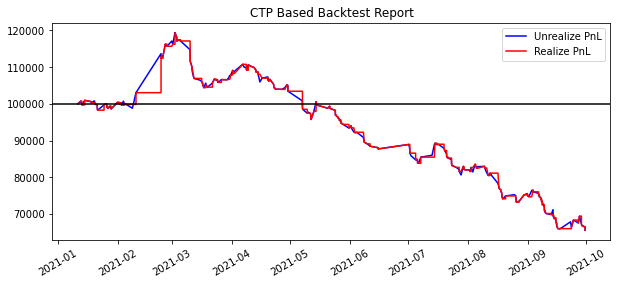

,开多,开空,减多,减空,反开,反空,平开,平空,全平
Actions,133,120,0,0,0,0,104,104,0


,Ticks Modelled,Initial Capital,Final Capital,Realized PnL,Return,MaxDrawdown,MaxDrawdown Ratio,Win Rate,Win Rate (Long),Win Rate (Short),PnL Ratio,PnL Ratio (Long),PnL Ratio (Short),EPO,EPO (Long),EPO (Short)
Stats,5853022,100000,65559.15,-34440.85,-34.4,53817.22,0.45,0.26,0.29,0.23,0.67,0.81,0.51,-160.75,-94.62,-226.89


In [5]:
%reload_ext autoreload
%autoreload 2


from backtest2 import backtest
import pandas as pd
import numpy as np
import database as db
import helpers
import metrics
import os
import matplotlib.pyplot as plt


data_path = './data'

start_date = '20210110'
end_date = '20211001'
instrument = 'EG'
freq = '30min'
dates = np.array(db.GetTradeDates(instrument))
dates = dates[np.where((dates >= start_date) & (dates <= end_date))]
slippage = 5
capital = 100000
acc_id = '00001'
broker_rate = 1
ex_rebate = 0.10
br_rebate = 0.10

args = (instrument, slippage, acc_id, capital, broker_rate, ex_rebate, br_rebate)
bt = backtest(*args)
ff = big.ta.macd(fast=12, slow=26, signal=9, offset=0)
ff['TradeDate'] = big['TradeDate'].values

for date in dates:
    # Load Feature
    f = ff[ff.TradeDate == int(date)]
    f['sigl'] = np.where((f['MACDh_12_26_9'] > 0) & (f['MACDh_12_26_9'].shift(1) < 0),  1,
                np.where((f['MACDh_12_26_9'] < 0) & (f['MACDh_12_26_9'].shift(1) > 0),  4,
                0))
    f['sigs'] = np.where((f['MACDh_12_26_9'] > 0) & (f['MACDh_12_26_9'].shift(1) < 0),  -4,
                np.where((f['MACDh_12_26_9'] < 0) & (f['MACDh_12_26_9'].shift(1) > 0),  -1,
                0))
    # Load Bktest dateframe
    df = pd.read_csv(data_path + os.sep + instrument + os.sep + date + '.csv', index_col=0, parse_dates=True)
    df['MidPrice'] = 0.5* (df['BidPrice1'] + df['AskPrice1'])
    temp = pd.merge_asof(df.index.to_frame().set_index('datetime'), f[['sigl', 'sigs']], left_index=True, right_index=True, direction='backward', tolerance=pd.Timedelta('30s'))
    df['sigl'] = helpers.SignalFilter(temp['sigl'].values)
    df['sigs'] = helpers.SignalFilter(temp['sigs'].values)    
    #print(date)
    bt.run(df)
    
par = pd.DataFrame({
    'Instrument': instrument,
    'Period': '{} - {}'.format(start_date, end_date),
    'Freq': freq,
    'Exchange Rebate': ex_rebate,
    'Broker Rebate': br_rebate,
    'slippage': '{} ticks'.format(slippage)
}, index=['Value'])
display(par)

res = bt.result()
res.set_index('datetime', inplace=True)
fig = plt.figure(figsize=(10, 4))
plt.plot(res['total_pnl'], '-', color='blue', label='Unrealize PnL')
plt.plot(res['total_rpnl'], '-', color='red', label='Realize PnL')
plt.axhline(y=bt.capital, color='black', linestyle='-')
plt.xticks(rotation=30)
plt.title('CTP Based Backtest Report')
plt.legend()
plt.show()

counts = pd.DataFrame({
    '开多': len(res[(res['direction']== '多') & (res['action'].str.contains('开'))]),
    '开空': len(res[(res['direction']== '空') & (res['action'].str.contains('开'))]),
    '减多': len(res[(res['direction']== '多') & (res['action'].str.contains('减'))]),
    '减空': len(res[(res['direction']== '空') & (res['action'].str.contains('减'))]),
    '反开': len(res[(res['direction']== '多') & (res['action'].str.contains('反'))]),
    '反空': len(res[(res['direction']== '空') & (res['action'].str.contains('反'))]),
    '平开': len(res[(res['direction']== '多') & (res['action'].str.contains('平'))]),
    '平空': len(res[(res['direction']== '空') & (res['action'].str.contains('平'))]),
    '全平': len(res[(res['action'].str.contains('全'))]),
}, index=['Actions'])
display(counts)

acc = pd.DataFrame({
    'Ticks Modelled': int(bt.ticks),
    'Initial Capital': bt.capital,
    'Final Capital': res['total_rpnl'].iloc[-1],
    'Realized PnL': res['r_pnl'].sum(),
    'Return': round((res['total_rpnl'].iloc[-1] / bt.capital  - 1) * 100,1) ,
    'MaxDrawdown': metrics.GetDrawdown(res, ratio=False),
    'MaxDrawdown Ratio': metrics.GetDrawdown(res, ratio=True),
    'Win Rate': metrics.GetWinRate(res),
    'Win Rate (Long)': metrics.GetWinRate(res, side='long'),
    'Win Rate (Short)': metrics.GetWinRate(res, side='short'),
    'PnL Ratio': metrics.GetPnLRatio(res),
    'PnL Ratio (Long)': metrics.GetPnLRatio(res, side='long'),
    'PnL Ratio (Short)': metrics.GetPnLRatio(res, side='short'),
    'EPO': metrics.GetEPO(res),
    'EPO (Long)': metrics.GetEPO(res, 'long'),
    'EPO (Short)': metrics.GetEPO(res, 'short'),
}, index=['Stats'])
display(acc)


In [ ]:
df[df['sigl'] > 0]